# 🏥 Visual AI in Healthcare with FiftyOne – Fine-tuning YOLOv8 for Stenosis Detection  
**Train, evaluate, and visualize a YOLOv8 object detection model using the curated ARCADE dataset**

This notebook is part of the **“Visual AI in Healthcare with FiftyOne”** workshop. In this hands-on exercise, you'll learn how to fine-tune a YOLOv8 object detection model for stenosis detection using a subset of the ARCADE dataset. The subset is curated through embedding-based selection methods described in previous notebooks. This notebook demonstrates how to fine-tune a YOLOv8 model on a curated subset of 300 images with `stenosis` from the ARCADE dataset using FiftyOne and Ultralytics' YOLOv8 integration.

🧠 **What you’ll learn in this notebook:**

- How to **prepare and export a YOLOv8-compatible dataset** from FiftyOne  
- How to **fine-tune YOLOv8** on a small but representative subset  
- How to **run inference on test data** using the fine-tuned model  
- How to **load predictions into FiftyOne** for evaluation  
- How to **compare model predictions** with ground truth annotations  

📚 **Part of the notebook series:**
1. `01_load_arcade_dataset.ipynb` – Load and visualize the ARCADE dataset.  
2. `02_load_deeplesion_balanced.ipynb` – Curate and balance the DeepLesion dataset.  
3. `03_vlms_analysis_arcade.ipynb` – Use VFMs like NVLabs_CRADIOV3 in dataset undersatnding for ARCADE. 
4. `04_finetune_yolo8_stenosis.ipynb` – Train and integrate YOLOv8 for stenosis detection.  
5. `05_medsam2_ct_scan.ipynb` – Run MedSAM2 on CT scans for segmentation.  
6. `06_nvidia_vista_segmentation.ipynb` – Explore NVIDIA-VISTA-3D.  
7. `07_medgemma_vqa.ipynb` – Perform visual question answering and classification with MedGemma.

All notebooks are standalone but are best experienced sequentially.

### ✅ Requirements

Please install all the requeriments for running this notebook. And import the libraries.

In [2]:
# Step 1: Imports
import fiftyone as fo
import fiftyone.utils.random as four
from ultralytics import YOLO
import os

### 📦 Load and Prepare the ARCADE Subset for Fine-Tuning

In this step, we prepare the curated subset of the ARCADE dataset for training a YOLOv8 model.

- We first **check if an existing FiftyOne dataset** with the same name exists and delete it if necessary to avoid conflicts.
- Then we **load the dataset** from disk using the `YOLOv5Dataset` format (supported in FiftyOne for YOLOv5/YOLOv8-style annotations).
- The dataset is then **launched in the FiftyOne App** for visual inspection.
- Next, we **split the dataset** into training and validation sets (80/20) using `fiftyone.utils.random`.
- Finally, we **extract the class labels** from the segmentation annotations and **export** the dataset back to disk in YOLO format, ready for training.

> 📌 Note: This step assumes you previously exported the curated subset of ARCADE using FiftyOne. The loaded dataset will be used to fine-tune a YOLOv8 object detection model.


In [23]:
# Name of the existing dataset
#dataset_name = "arcade_subset_loaded"
dataset_name = "arcade_subset_test"


# Delete it if it exists
if fo.dataset_exists(dataset_name):
    fo.delete_dataset(dataset_name)
    print(f"Deleted existing dataset: {dataset_name}")
else:
    print(f"No dataset found with name: {dataset_name}")


Deleted existing dataset: arcade_subset_test


 100% |█████████████████| 299/299 [194.7ms elapsed, 0s remaining, 1.5K samples/s]  



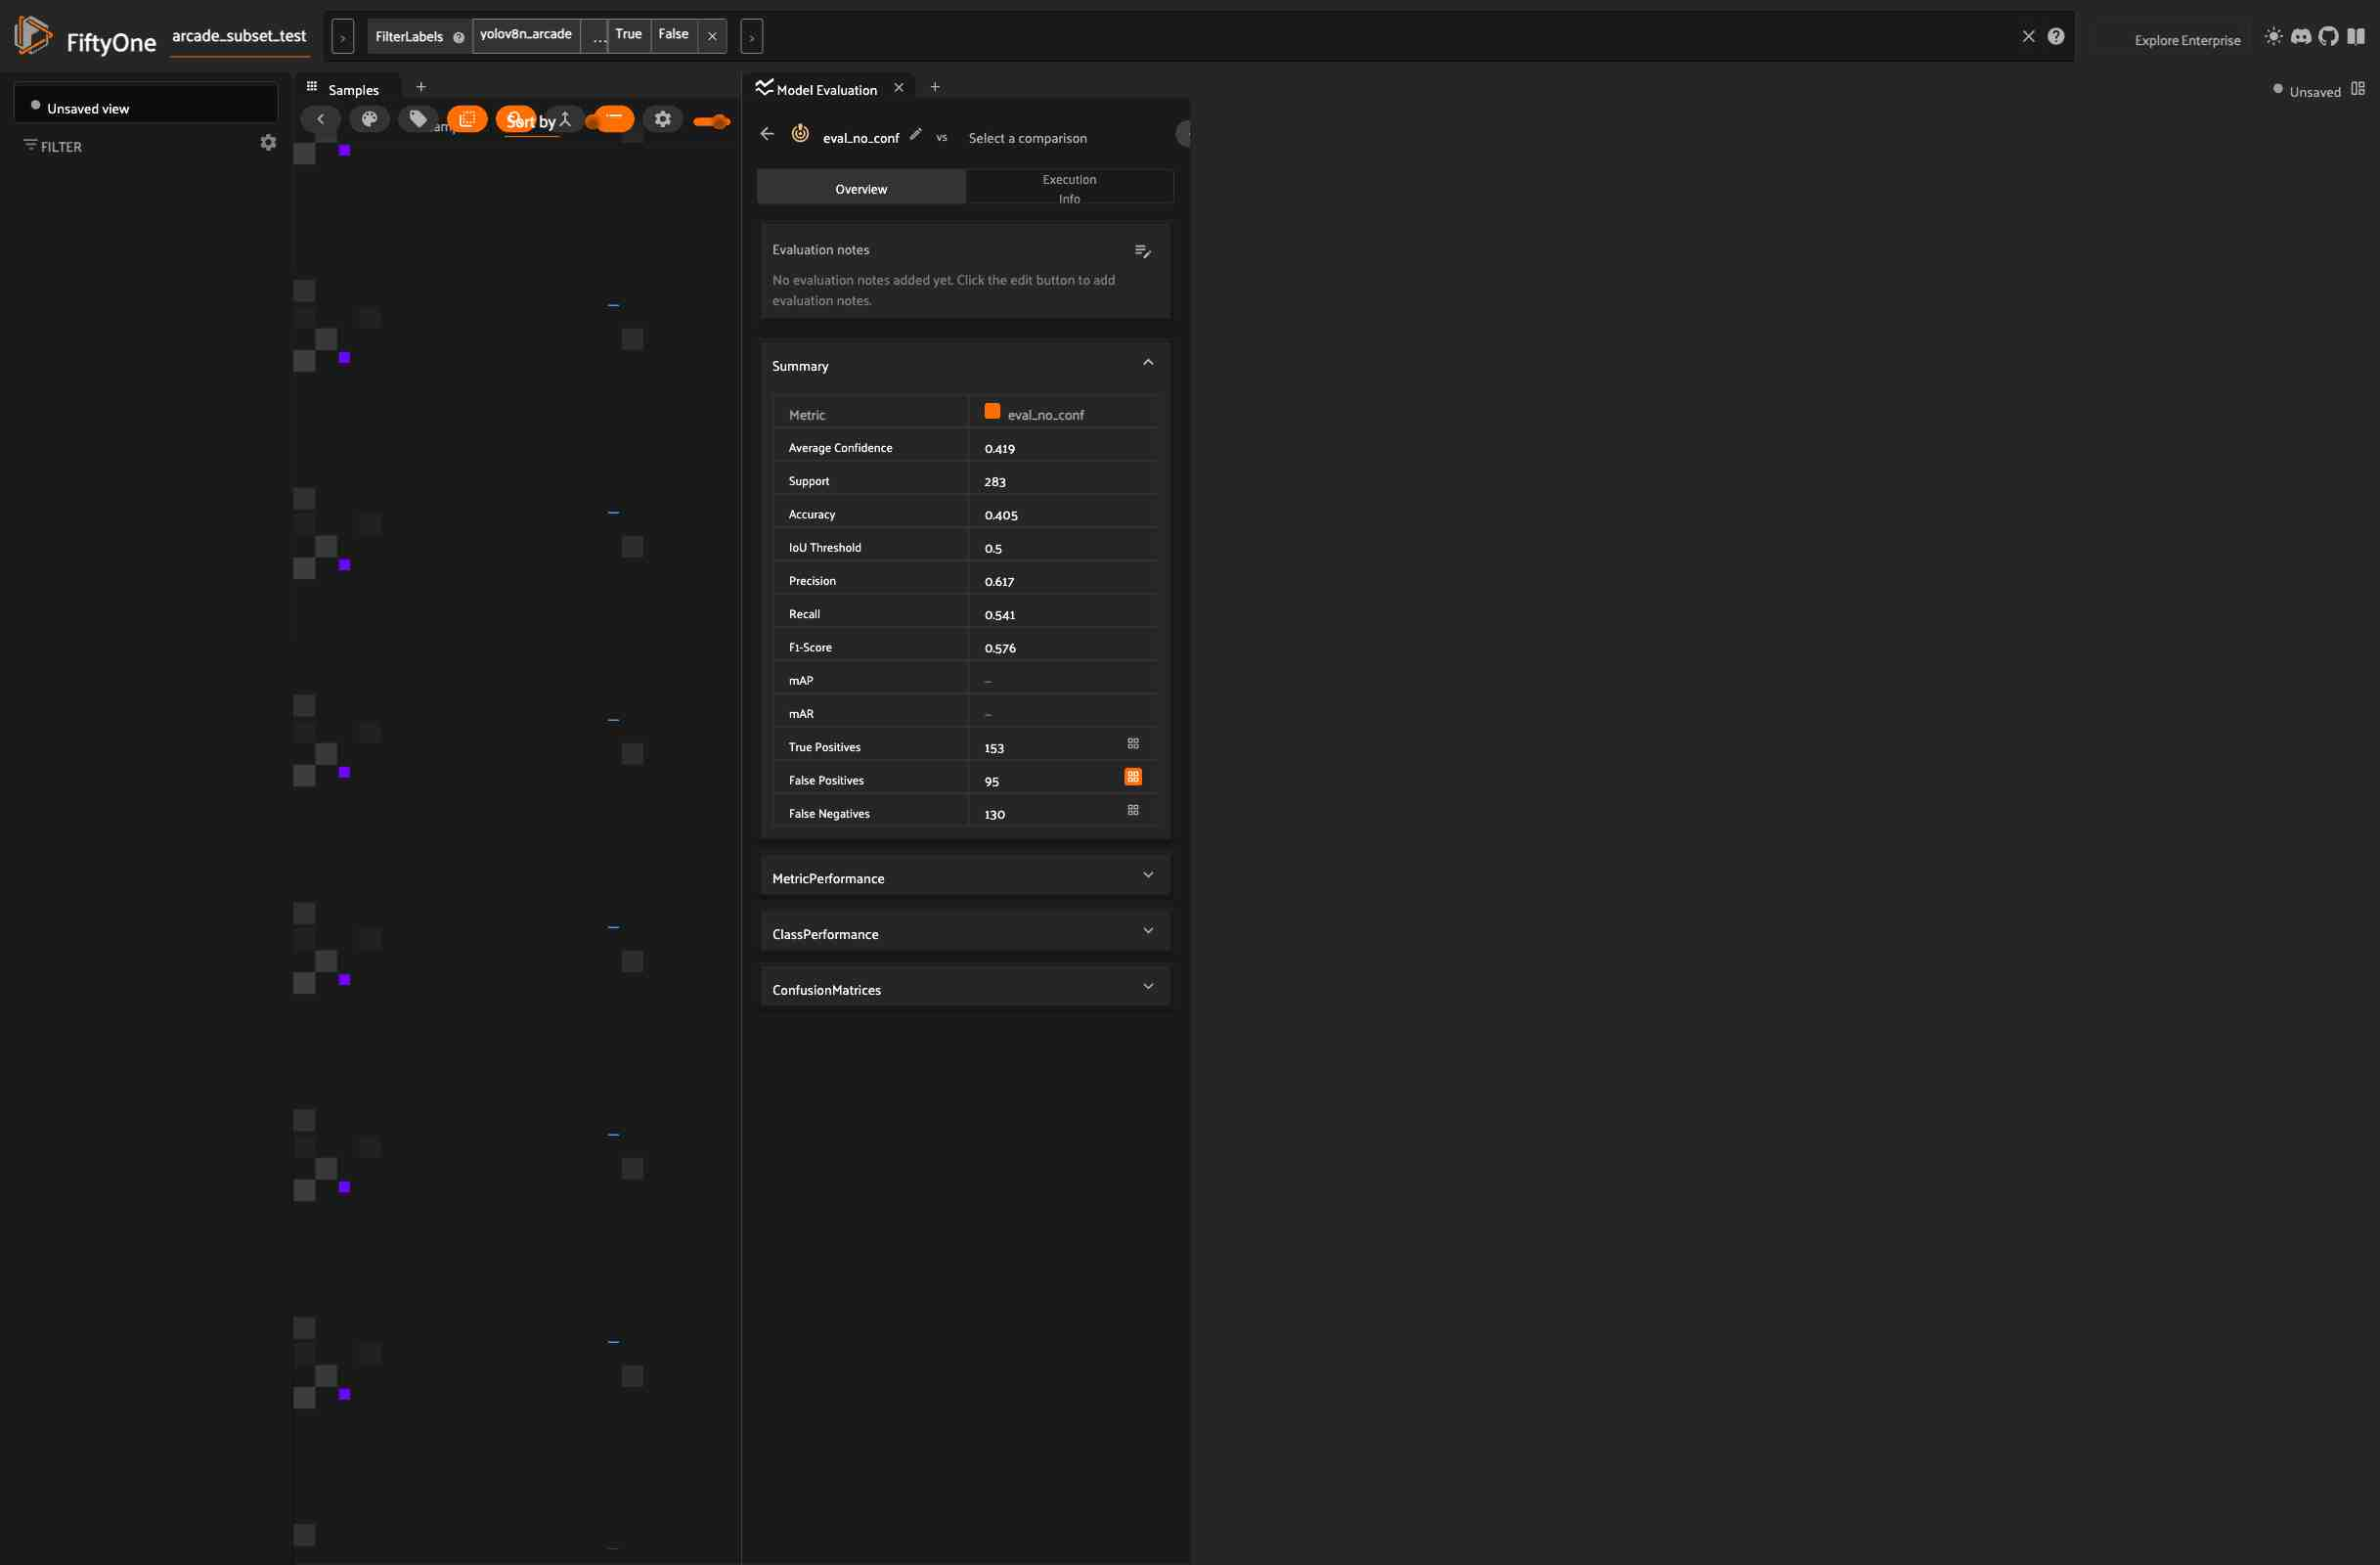

In [13]:
import fiftyone.types as fot

# Define the path to your exported YOLOv8 dataset
dataset_dir = "arcade_yolo_subset"  # <-- this should match your previous export_dir

import fiftyone as fo
import fiftyone.types as fot

dataset = fo.Dataset.from_dir(
    dataset_dir="arcade_yolo_subset",
    dataset_type=fot.YOLOv5Dataset,
    split="train",  # match what was exported
    label_field="segmentations",
    name="arcade_subset_loaded",
)
# Launch FiftyOne App to visualize
session = fo.launch_app(dataset)

In [14]:
# Step 3: Train/Val Split (80/20)
dataset.untag_samples(dataset.distinct("tags"))
four.random_split(dataset, {"train": 0.8, "val": 0.2})

In [15]:
# Step 4: Extract Classes from Segmentations
label_field = "segmentations"
classes = sorted({
    det.label
    for sample in dataset.select_fields(label_field)
    if sample[label_field] is not None
    for det in sample[label_field].detections
})
print("Classes:", classes)

Classes: ['stenosis']


In [ ]:
# Step 5: Export to YOLO Format
export_dir = "./arcade_yolo"
export_yolo_data(
    dataset,
    export_dir,
    classes=classes,
    label_field=label_field,
    split=["train", "val"]
)

### 🏋️ Fine-Tune the YOLOv8 Model (Run in Terminal)

Now that the dataset is prepared and exported in YOLO format, we fine-tune a YOLOv8 model using the [Ultralytics CLI](https://docs.ultralytics.com/cli/train/).

The command below uses the `yolov8n.pt` (YOLOv8 Nano) pretrained model and trains it on our exported dataset:

```bash
yolo task=detect mode=train \
  model=yolov8n.pt \
  data=arcade_yolo/dataset.yaml \
  epochs=60 imgsz=640 batch=16
```

Follow this [documentation](https://docs.voxel51.com/tutorials/yolov8.html?highlight=fine%20tune) for Fine-Tuning process with Ultralytics.

In [ ]:
!yolo task=detect mode=train model=yolov8n.pt data=arcade_yolo_subset/dataset.yaml epochs=60 imgsz=640 batch=16

New https://pypi.org/project/ultralytics/8.3.162 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.159 🚀 Python-3.10.17 torch-2.7.1 CPU (Apple M3 Max)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=arcade_yolo_subset/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer

### Run Inference with Fine-Tuned YOLOv8 Model

Once training is complete, we can use the best weights to run inference on the validation set. The following command uses the `yolo` CLI to perform predictions:

```bash
!yolo task=detect mode=predict \
  model=/Users/paularamos/Documents/GitHub/awesome-fiftyone/runs/detect/train2/weights/best.pt \
  source=arcade_yolo_subset/images/val \
  save_txt=True \
  save_conf=True


In [18]:
!yolo task=detect mode=predict model=/Users/paularamos/Documents/GitHub/awesome-fiftyone/runs/detect/train2/weights/best.pt source=arcade_yolo_subset/images/val save_txt=True save_conf=True

Ultralytics 8.3.159 🚀 Python-3.10.17 torch-2.7.1 CPU (Apple M3 Max)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

image 1/179 /Users/paularamos/Documents/FiftyOne_HealthCare_Workshop/arcade_yolo_subset/images/val/1-3.png: 640x640 (no detections), 37.2ms
image 2/179 /Users/paularamos/Documents/FiftyOne_HealthCare_Workshop/arcade_yolo_subset/images/val/10-6.png: 640x640 (no detections), 36.6ms
image 3/179 /Users/paularamos/Documents/FiftyOne_HealthCare_Workshop/arcade_yolo_subset/images/val/101-3.png: 640x640 4 stenosiss, 37.1ms
image 4/179 /Users/paularamos/Documents/FiftyOne_HealthCare_Workshop/arcade_yolo_subset/images/val/102-6.png: 640x640 (no detections), 34.8ms
image 5/179 /Users/paularamos/Documents/FiftyOne_HealthCare_Workshop/arcade_yolo_subset/images/val/103-6.png: 640x640 3 stenosiss, 36.5ms
image 6/179 /Users/paularamos/Documents/FiftyOne_HealthCare_Workshop/arcade_yolo_subset/images/val/108-3.png: 640x640 (no detections), 37.1ms
image 7/17

### Load Predictions into FiftyOne

After running inference, we now load the predictions into our FiftyOne dataset for visualization and evaluation.

### Step 1: Load the validation split of the YOLOv5-style dataset

We use FiftyOne's `Dataset.from_dir()` method to load the validation set from the `arcade_yolo_subset` directory. The dataset is in `YOLOv5Dataset` format. We assign the labels to the `ground_truth` field for later comparison.

This allows us to later visualize both the ground truth and the predicted detections in the same FiftyOne session.


In [ ]:
import fiftyone as fo
import fiftyone.utils.yolo as fouy

# Load original dataset
dataset_ = fo.Dataset.from_dir(
    dataset_dir="arcade_yolo_subset",
    dataset_type=fo.types.YOLOv5Dataset,
    split="val",
    label_field="ground_truth",
    name="arcade_subset_test",
)

### Step 2: Define utility functions to read and convert YOLOv8 predictions

We define the following helper functions:

- `get_prediction_filepath`: builds the filepath to the YOLOv8 prediction `.txt` file corresponding to each image.
- `read_yolo_detections_file`: reads a prediction `.txt` file and extracts bounding box data.
- `convert_yolo_detections_to_fiftyone`: converts YOLO-format detections into FiftyOne's `Detection` objects.
- `_uncenter_boxes`: converts YOLO box format (center x/y, width, height) to FiftyOne box format (top-left x/y, width, height).
- `_get_class_labels`: maps YOLO class indices to class labels using the dataset's class list.

These functions are used to transform YOLOv8 predictions into a format that can be visualized and analyzed within FiftyOne.


In [42]:
def get_prediction_filepath(filepath, run_number = 1):
    run_num_string = ""
    if run_number != 1:
        run_num_string = str(run_number)
    filename = filepath.split("/")[-1].split(".")[0]
    return f"/Users/paularamos/Documents/GitHub/awesome-fiftyone/runs/detect/predict/labels/{filename}.txt"

def add_yolo_detections(
    samples,
    prediction_field,
    prediction_filepath,
    class_list
    ):

    prediction_filepaths = samples.values(prediction_filepath)
    yolo_detections = [read_yolo_detections_file(pf) for pf in prediction_filepaths]
    detections =  [convert_yolo_detections_to_fiftyone(yd, class_list) for yd in yolo_detections]
    samples.set_values(prediction_field, detections)

def read_yolo_detections_file(filepath):
    detections = []
    if not os.path.exists(filepath):
        return np.array([])

    with open(filepath) as f:
        lines = [line.rstrip('\n').split(' ') for line in f]

    for line in lines:
        detection = [float(l) for l in line]
        detections.append(detection)
    return np.array(detections)

def convert_yolo_detections_to_fiftyone(
    yolo_detections,
    class_list
    ):

    detections = []
    if yolo_detections.size == 0:
        return fo.Detections(detections=detections)

    boxes = yolo_detections[:, 1:-1]
    _uncenter_boxes(boxes)

    confs = yolo_detections[:, -1]
    labels = _get_class_labels(yolo_detections[:, 0], class_list)

    for label, conf, box in zip(labels, confs, boxes):
        detections.append(
            fo.Detection(
                label=label,
                bounding_box=box.tolist(),
                confidence=conf
            )
        )

    return fo.Detections(detections=detections)

def _uncenter_boxes(boxes):
    '''convert from center coords to corner coords'''
    boxes[:, 0] -= boxes[:, 2]/2.
    boxes[:, 1] -= boxes[:, 3]/2.

def _get_class_labels(predicted_classes, class_list):
    labels = (predicted_classes).astype(int)
    labels = [class_list[l] for l in labels]
    return labels

### Step 3: Load YOLOv8 predictions and add them to the dataset

We generate the list of prediction filepaths for the images in the validation split using `get_prediction_filepath`.

Then, we use `add_yolo_detections()` to load predictions from disk, convert them to FiftyOne `Detection` objects, and attach them to each sample under the field `yolov8n_arcade`.

This prepares the dataset for qualitative or quantitative evaluation of YOLOv8 predictions within FiftyOne.


In [43]:
import numpy as np

filepaths = dataset_.values("filepath")
prediction_filepaths = [get_prediction_filepath(fp, run_number=2) for fp in filepaths]

dataset_.set_values(
    "yolov8n_arcade_det_filepath",
    prediction_filepaths
)

add_yolo_detections(
    dataset_,
    "yolov8n_arcade",
    "yolov8n_arcade_det_filepath",
    classes
)



In [44]:
session = fo.launch_app(dataset_, port=5151, auto=False)

Session launched. Run `session.show()` to open the App in a cell output.


### Evaluating YOLOv8 Results with FiftyOne Plugins

FiftyOne supports powerful evaluation capabilities through its plugin system. With the [`@voxel51/evaluation`](https://github.com/voxel51/fiftyone-plugins) plugin, you can evaluate detection, classification, segmentation, and regression models directly from the UI or Python SDK.

#### 🔌 Plugin Installation

To install the evaluation plugin, run the following command in your terminal:

```bash
fiftyone plugins download \
  https://github.com/voxel51/fiftyone-plugins \
  --plugin-names @voxel51/evaluation


### Run Detection Evaluation on YOLOv8 Predictions

Now that our YOLOv8 predictions are added to the dataset, we can evaluate them against the ground truth using FiftyOne's built-in `evaluate_detections` method.

In this example, we disable mAP computation (`compute_mAP=False`) since the predictions do not contain confidence scores.

```python
results = dataset_.evaluate_detections(
    "yolov8n_arcade",          # field with model predictions
    gt_field="ground_truth",   # ground truth field
    eval_key="eval_no_conf",   # identifier for this evaluation run
    compute_mAP=False          # skips mAP since we don't have confidence scores
)

results.print_report()


In [50]:
results = dataset_.evaluate_detections(
    "yolov8n_arcade",
    gt_field="ground_truth",
    eval_key="eval_no_conf",
    compute_mAP=False,  # Avoids needing confidence
)
results.print_report()


Evaluating detections...
 100% |█████████████████| 179/179 [229.4ms elapsed, 0s remaining, 780.2 samples/s]      
              precision    recall  f1-score   support

    stenosis       0.62      0.54      0.58       283

   micro avg       0.62      0.54      0.58       283
   macro avg       0.62      0.54      0.58       283
weighted avg       0.62      0.54      0.58       283



In [ ]:
dataset_.reload()
dataset_.persistent=True
print(dataset_)

Name:        arcade_subset_test
Media type:  image
Num samples: 179
Persistent:  True
Tags:        []
Sample fields:
    id:                          fiftyone.core.fields.ObjectIdField
    filepath:                    fiftyone.core.fields.StringField
    tags:                        fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:                  fiftyone.core.fields.DateTimeField
    last_modified_at:            fiftyone.core.fields.DateTimeField
    ground_truth:                fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    yolov8n_arcade_det_filepath: fiftyone.core.fields.StringField
    yolov8n_arcade:              fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    yolo_eval_tp:                fiftyone.core.fields.IntField
    yolo_eval_fp:                fiftyone.core.fields.